# Lab 1: Data Access

This notebook demonstrates how to access and work with habitat data using the `habitat_pl` library.

## Setup

First, let's import the necessary modules:

In [5]:
import sys
sys.path.append('../src')

import habitat_pl
from habitat_pl import config, ee_auth
from habitat_pl.data import embeddings, labels
from habitat_pl.viz import maps

## Configuration

Check the configuration:

In [6]:
cfg = config.get_config()
print(f"Version: {cfg['version']}")

Version: 0.1.0


## Earth Engine Authentication

Authenticate and initialize Earth Engine (uncomment when ready to use):

In [7]:
# ee_auth.authenticate()
ee_auth.initialize()

## Data Access

Examples of accessing data will be added here.

In [8]:
import ipywidgets as widgets
import habitat_pl.viz.corine as corine
import importlib
import geemap
import ee

importlib.reload(corine)

<module 'habitat_pl.viz.corine' from 'c:\\space_technologies\\semestr_2\\machine_learning\\yosef\\agh-habitat-pl\\notebooks\\../src\\habitat_pl\\viz\\corine.py'>

In [9]:
region_1 = (ee.FeatureCollection('FAO/GAUL/2015/level1')
          .filter(ee.Filter.eq('ADM1_NAME', 'Mazowieckie'))
          .geometry())

region_2 = (ee.FeatureCollection('FAO/GAUL/2015/level1')
          .filter(ee.Filter.eq('ADM1_NAME', 'Podkarpackie'))
          .geometry())

# Annual Satellite Embedding (example: 2021)
emb_1 = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
       .filterDate('2018-01-01','2019-01-01')
       .filterBounds(region_1)
       .mosaic()
       .clip(region_1))

emb_2 = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
       .filterDate('2018-01-01','2019-01-01')
       .filterBounds(region_2)
       .mosaic()
       .clip(region_2))


In [23]:
m = geemap.Map()
both_regions = region_1.union(region_2)
m.centerObject(both_regions, 6) 

In [24]:
# Visualize (pseudo-RGB from embedding bands)
m.addLayer(emb_1, {'min':-0.3,'max':0.3,'bands':['A01','A16','A09']}, 'Mazowieckie')
m.addLayer(emb_2, {'min':-0.3,'max':0.3,'bands':['A01','A16','A09']}, 'Podkarpackie')
m

Map(center=[51.539304248295096, 21.473467801038264], controls=(WidgetControl(options=['position', 'transparent…

In [12]:
# Loads CORINE Land Cover 2018 raster (44 classes, 100 m resolution).
clc = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(both_regions)

# Remaps CORINE class codes (111…523) to sequential indices (1…44).
clc_idx = clc.remap(corine.codes, list(range(1, len(corine.codes)+1))).rename('landcover_idx')

# Adds the CORINE raster to the map, colored according to EEA’s palette
m.addLayer(clc_idx, corine.vis, 'CORINE 2018')

# Creates a scrollable legend showing all 44 class names with their corresponding colors.
legend = m.add_legend(title="CORINE Land Cover 2018", legend_dict=corine.legend_dict)

m

Map(bottom=5746.0, center=[51.539304248295096, 21.473467801038264], controls=(WidgetControl(options=['position…

Found 64 embedding bands. Example: ['A00', 'A01', 'A02', 'A03', 'A04', 'A05']
downloading data from Earth Engine...
downloaded 5000 samples. Columns: ['A00', 'A01', 'A02', 'A03', 'A04', 'A05'] ...
dropna: 5000 samples.
PCA done. Explained variance ratios: 0.5460468584454654
t-SNE done.
UMAP (all dims) done.
UMAP (64-d or all dims if <64) done.
Number of distinct CORINE classes in sample: 17


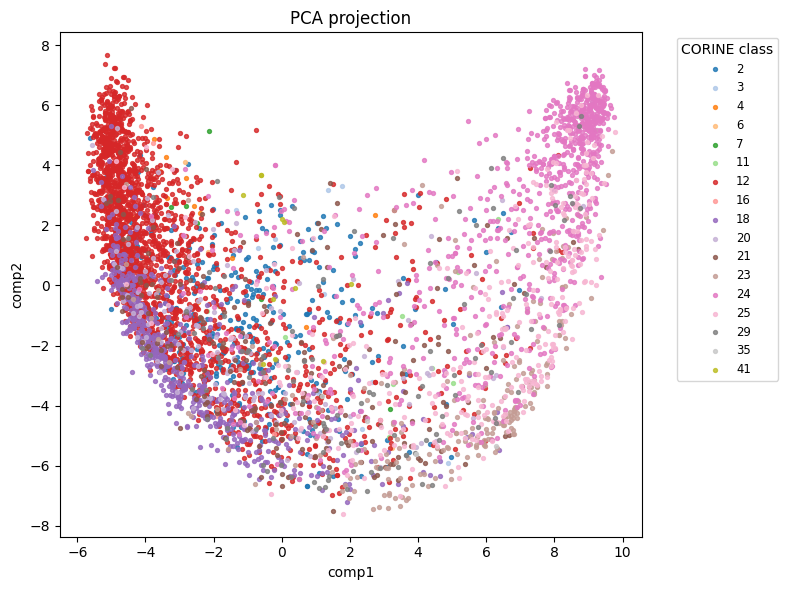

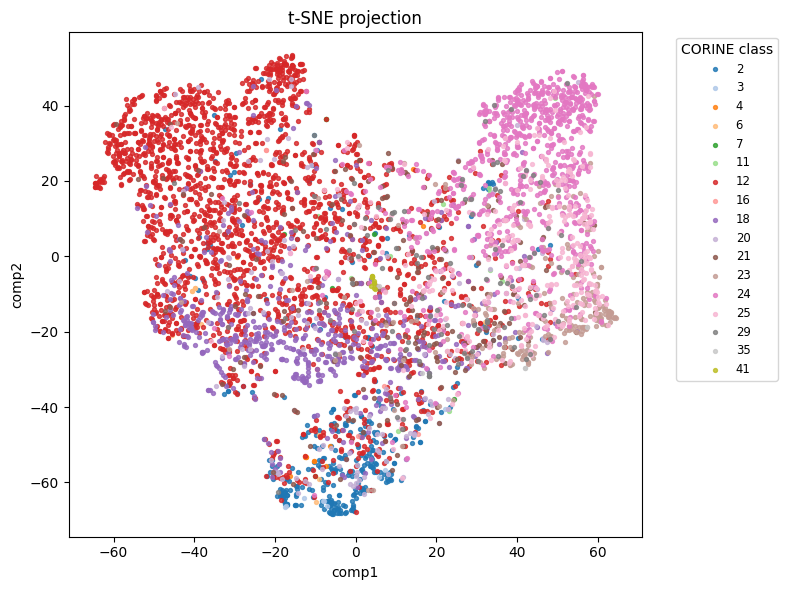

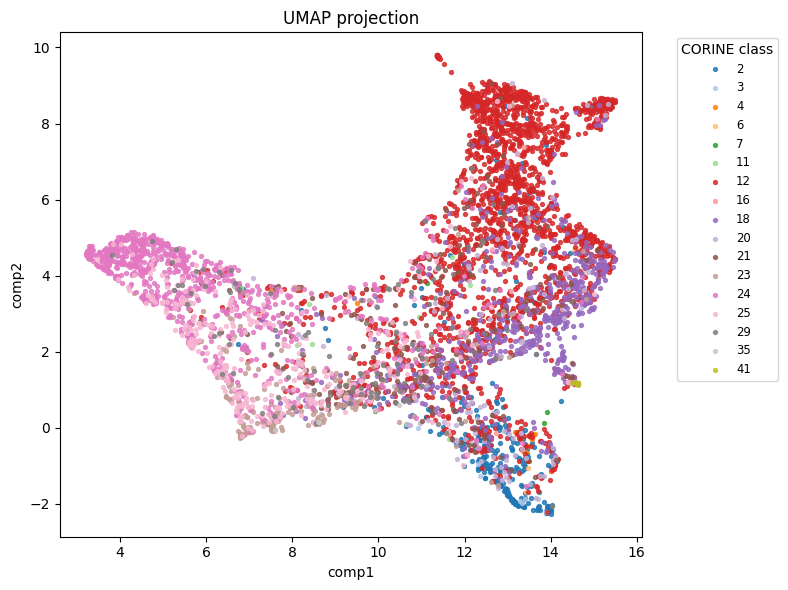

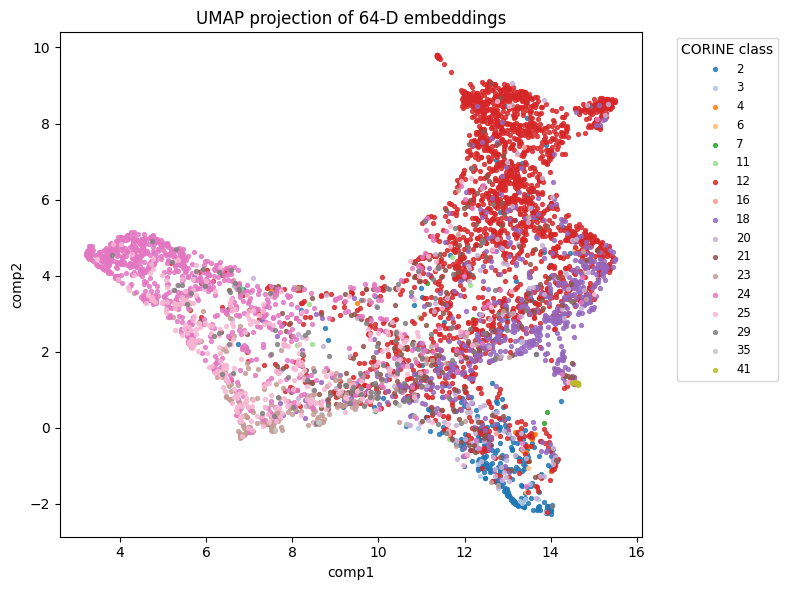

saved: proj_pca.png, proj_tsne.png, proj_umap.png, proj_umap64.png


In [22]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

aoi = m.draw_last_feature

# User settings
num_samples = 5000 # how much points
scale = 100 # downloading scale, for CORINE 100m
random_state = 42

# preparing bands
# bands in embeddings
emb_bandnames = emb_1.bandNames().getInfo()
print(f"Found {len(emb_bandnames)} embedding bands. Example: {emb_bandnames[:6]}")


# for umap 64-d taking only 64 bands
n_bands = len(emb_bandnames)
use_bands = emb_bandnames
use_bands_64 = emb_bandnames[:64] if n_bands >= 64 else emb_bandnames


combined = emb_1.select(use_bands).addBands(clc_idx.rename('clc'))

if isinstance(aoi, ee.Feature):
    aoi = aoi.geometry()
elif isinstance(aoi, ee.FeatureCollection):
    aoi = aoi.geometry()

# downloading AOI samples

samples_fc = combined.sample(region=aoi, scale=scale, numPixels=num_samples, geometries=True, seed=random_state)


print('downloading data from Earth Engine...')
features = samples_fc.getInfo()


records = []
for f in features['features']:
  props = f['properties']
  if props is None:
    continue
  if props.get('clc') is None:
    continue
  row = {b: props.get(b, None) for b in use_bands}
  row['clc'] = props['clc']
  geom = f.get('geometry')
  if geom:
    coords = geom.get('coordinates')
    row['lon'] = coords[0]
    row['lat'] = coords[1]
  records.append(row)


if len(records) == 0:
  raise RuntimeError('the lack of samples')


df = pd.DataFrame.from_records(records)
print(f'downloaded {len(df)} samples. Columns: {list(df.columns)[:6]} ...')


# delete rows with lacking values
df = df.dropna()
print(f'dropna: {len(df)} samples.')


X = df[use_bands].values.astype(float)
y = df['clc'].astype(int).values


# normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



# doing projections
# PCA 2D
pca = PCA(n_components=2, random_state=random_state)
X_pca = pca.fit_transform(X_scaled)
print('PCA done. Explained variance ratios:', pca.explained_variance_ratio_.sum())


# t-SNE 2D
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=random_state, init='pca')
X_tsne = tsne.fit_transform(X_scaled)
print('t-SNE done.')


# UMAP 2D
umapper = umap.UMAP(n_components=2, random_state=random_state)
X_umap = umapper.fit_transform(X_scaled)
print('UMAP (all dims) done.')


# UMAP 64 vector
if len(use_bands_64) < X.shape[1]:
  idx64 = list(range(len(use_bands_64)))
  X64 = X[:, idx64]
  X64s = StandardScaler().fit_transform(X64)
else:
  X64s = X_scaled


umapper64 = umap.UMAP(n_components=2, random_state=random_state)
X_umap64 = umapper64.fit_transform(X64s)
print('UMAP (64-d or all dims if <64) done.')

# plotting

unique_classes = np.unique(y)
n_classes = len(unique_classes)
print(f'Number of distinct CORINE classes in sample: {n_classes}')



cmap = plt.get_cmap('tab20')
colors = [cmap(i % 20) for i in range(n_classes)]
class_to_color = {cls: colors[i] for i, cls in enumerate(unique_classes)}



def plot_scatter(X2, title, fname):
  plt.figure(figsize=(8,6))
  for cls in unique_classes:
    mask = (y == cls)
    plt.scatter(X2[mask,0], X2[mask,1], s=8, alpha=0.8, label=str(int(cls)), color=class_to_color[cls])
  plt.legend(title='CORINE class', bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
  plt.title(title)
  plt.xlabel('comp1')
  plt.ylabel('comp2')
  plt.tight_layout()
  plt.savefig(fname, dpi=200)
  plt.show()


plot_scatter(X_pca, 'PCA projection', 'proj_pca.png')
plot_scatter(X_tsne, 't-SNE projection', 'proj_tsne.png')
plot_scatter(X_umap, 'UMAP projection', 'proj_umap.png')
plot_scatter(X_umap64, 'UMAP projection of 64-D embeddings', 'proj_umap64.png')


print('saved: proj_pca.png, proj_tsne.png, proj_umap.png, proj_umap64.png')

